<a href="https://colab.research.google.com/github/Exion007/Colab/blob/main/ensemble_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ensemble Learning

* Ensemble learning is a supervised machine learning technique that aims to improve the accuracy of the prediction.

* Ensemble methods combine predictions from multiple models.

* Ensemble methods are meta-algorithms that associate a variety of machine learning methods into a single predictive model to decrease variance by means of bagging, decrease bias by means of boosting, or improve predictions by means of stacking.

* We can classify ensemble methods into two main branches:
  1. Simple Ensemble Methods

  2. Advanced Ensemble Methods

# 1. Simple Ensemble Methods

* **Voting:**
  - Primarily used in classification problems.
  - Combine the predictions obtained from multiple models to come up with a final prediction.
  - Example: Elections (50% + 1)

* **Averaging:**
  - Primarily used in classification problems.
  - Similar to **'Voting'**, but it involves calculating the average of predicted probabilities.
  - Ex: (0.6 + 0.7 + 0.8) / 3 = 0.7

* **Weighted Averaging:**
  - Similar to **'Averaging'**, but each model's prediction is given a weight based on its reliability or performance.
  - Ex: [(0.6 * 0.1) + (0.7 * 0.3) + (0.8 * 0.6)] = 0.75


# 2. Advanced Ensemble Methods
  * **Bagging (Bootstrap Aggregating):**
    - Used in classification or regression problems
    - Multiple instances of the same model are trained on different subsets of the training data, each obtained through bootstrap resampling.
    - The final prediction is often an average or majority vote of predictions from each individual model.

    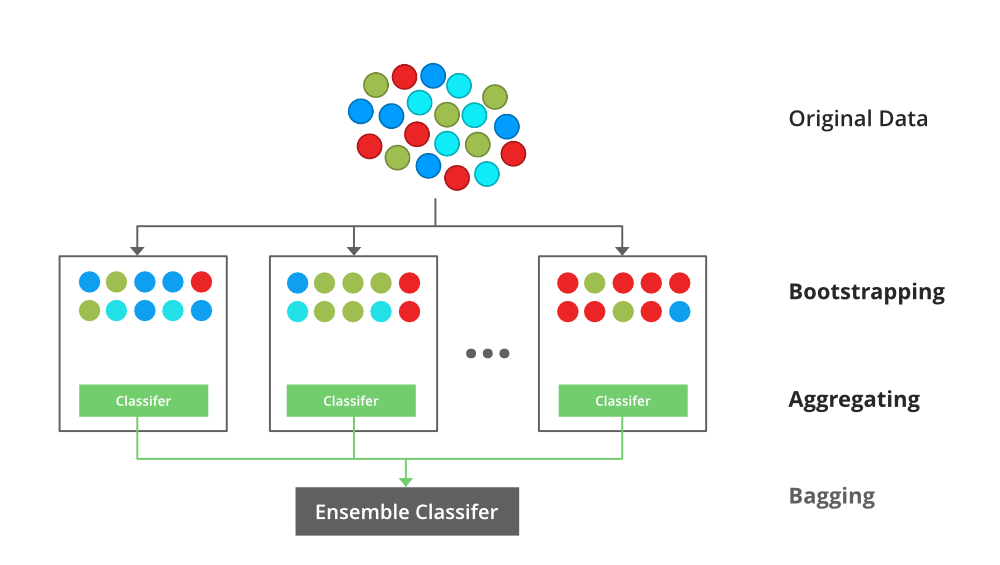


# Sample Training

In [23]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, recall_score, precision_score

In [24]:
# Reading file

df = pd.read_csv("movies.csv")
df.head(3)

,id,title,release_date,genres,original_language,vote_average,vote_count,popularity,overview,budget,production_companies,revenue,runtime,tagline
0,758323,The Pope's Exorcist,2023-04-05,"['Horror', 'Mystery', 'Thriller']",English,7.4,619,5089.969,"Father Gabriele Amorth, Chief Exorcist of the ...",18000000,"['Screen Gems', '2.0 Entertainment', 'Jesus & ...",65675816,103,Inspired by the actual files of Father Gabriel...
1,640146,Ant-Man and the Wasp: Quantumania,2023-02-15,"['Action', 'Adventure', 'Science Fiction']",English,6.6,2294,4665.438,Super-Hero partners Scott Lang and Hope van Dy...,200000000,"['Marvel Studios', 'Kevin Feige Productions']",464566092,125,Witness the beginning of a new dynasty.
2,502356,The Super Mario Bros. Movie,2023-04-05,"['Animation', 'Adventure', 'Family', 'Fantasy'...",English,7.5,1861,3935.550,"While working underground to fix a water main,...",100000000,"['Universal Pictures', 'Illumination', 'Ninten...",1121048165,92,NaN


In [25]:
# PREPROCESSING

# Selecting the columns we want to use
df = df.loc[:, ['vote_average', 'vote_count', 'genres', 'budget', 'popularity']]


# Replace the budget values given as 0 with the mean of the other budget values
avg = df.query("budget > 0").budget.mean()
df.loc[df["budget"] == 0, "budget"] = avg

# Drop NA values (We do not have any in this case)
df.dropna(inplace = True)

# Convert the genres column from string to list format
def convert_genres(row):
  row = row[1:-1].replace("'", "").split(", ")
  return row

df['genres'] = df['genres'].apply(convert_genres)

df.head(3)

,vote_average,vote_count,genres,budget,popularity
0,7.4,619,"[Horror, Mystery, Thriller]",18000000.0,5089.969
1,6.6,2294,"[Action, Adventure, Science Fiction]",200000000.0,4665.438
2,7.5,1861,"[Animation, Adventure, Family, Fantasy, Comedy]",100000000.0,3935.550


In [17]:
# Selecting the columns we want to operate on
X = df[['vote_count', 'genres', 'budget', 'popularity']]
y = df['vote_average']


# One hot encoding
mlb = MultiLabelBinarizer()

# Transform the genres column into binary columns
genres_encoded = pd.DataFrame(mlb.fit_transform(X['genres']), columns=mlb.classes_, index=X.index)

# Concatenate the encoded genres with the original features
X_encoded = pd.concat([X[['vote_count', 'budget', 'popularity']], genres_encoded], axis=1)

# Displaying Genres
genres = X_encoded.iloc[:, 4:].columns
print(genres)

X_encoded.head(3)

Index(['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Mystery',
       'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western'],
      dtype='object')


,vote_count,budget,popularity,,Action,Adventure,Animation,Comedy,Crime,Documentary,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,619,18000000.0,5089.969,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
1,2294,200000000.0,4665.438,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1861,100000000.0,3935.550,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

In [19]:
# Using Random Forest

model_rf = RandomForestRegressor()

model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

rf_mse = mean_squared_error(y_test, y_pred_rf)

print(f"Random Forest Regressor -> Mean Squared Error: {rf_mse}")
print(f"Random Forest Regressor -> Root Mean Squared Error: {rf_mse ** 0.5}")

# Convert predicted vote averages into binary classifications
threshold = 7.0  # Choose an appropriate threshold based on your problem
y_pred_binary_rf = [1 if pred >= threshold else 0 for pred in y_pred_rf]

# Convert actual vote averages into binary classifications using the same threshold
y_test_binary_rf = [1 if actual >= threshold else 0 for actual in y_test]

# Calculate recall and precision
# precision_rf = precision_score(y_test_binary_rf, y_pred_binary_rf)
# recall_rf = recall_score(y_test_binary_rf, y_pred_binary_rf)

# print(f"Random Forest Regressor -> Precision: {precision_rf}")
# print(f"Random Forest Regressor -> Recall: {recall_rf}")

Random Forest Regressor -> Mean Squared Error: 0.6433043475000001
Random Forest Regressor -> Root Mean Squared Error: 0.8020625583456693


In [20]:
# Using XGBoost

model_xgb = XGBRegressor()

model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_test)

xgb_mse = mean_squared_error(y_test, y_pred_xgb)

print(f"XGBoost -> Mean Squared Error: {xgb_mse}")
print(f"XGBoost -> Root Mean Squared Error: {xgb_mse ** 0.5}")

# Convert predicted vote averages into binary classifications
threshold = 7.0  # Choose an appropriate threshold based on your problem
y_pred_binary_xgb = [1 if pred >= threshold else 0 for pred in y_pred_xgb]

# Convert actual vote averages into binary classifications using the same threshold
y_test_binary_xgb = [1 if actual >= threshold else 0 for actual in y_test]

# Calculate recall and precision
# precision_xgb = precision_score(y_test_binary_xgb, y_pred_binary_xgb)
# recall_xgb = recall_score(y_test_binary_xgb, y_pred_binary_xgb)

# print(f"XGBoost -> Precision: {precision_xgb}")
# print(f"XGBoost -> Recall: {recall_xgb}")

XGBoost -> Mean Squared Error: 0.6134430232279932
XGBoost -> Root Mean Squared Error: 0.7832260358466087


In [21]:
base_models = [
    ('random_forest', RandomForestRegressor()),
    ('xgboost', XGBRegressor())
]

# Define meta-model
meta_model = XGBRegressor()  # You can choose a different model for the meta-model

# Create the stacking regressor
model_ensemble = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Train the ensemble model
model_ensemble.fit(X_train, y_train)

# Predict on the testing set
y_pred_ens = model_ensemble.predict(X_test)

# Calculate Mean Squared Error
ens_mse = mean_squared_error(y_test, y_pred_ens)

print(f"Ensemble -> Mean Squared Error: {ens_mse}")
print(f"Ensemble -> Root Mean Squared Error: {ens_mse ** 0.5}")

Ensemble -> Mean Squared Error: 0.7015685182951388
Ensemble -> Root Mean Squared Error: 0.8375968709917312


In [22]:
# Get the input from the user, and display ratings produced using algorithms

# Function to input genres. Get genre input from the user until user inputs "exit"

def input_genres():
  genres = []
  x = True
  while (x):
    genre = str(input("Enter genre: ").lower().capitalize())

    if (genre.lower() == "exit"):
      x = False

    else:
      if genre not in genres:
        genres.append(genre)

  return genres

# Get inputs
new_vote_count = int(input("Enter vote count: "))
new_budget = int(input("Enter budget: "))
new_genres = input_genres()
new_popularity = float(input("Enter popularity: "))

# Example prediction for new data
new_data = pd.DataFrame({
    'vote_count': [new_vote_count],
    'genres': [new_genres],
    'budget': [new_budget],
    'popularity': [new_popularity]
})

# Transform the genres for the new data
new_data_genres_encoded = pd.DataFrame(mlb.transform(new_data['genres']), columns=mlb.classes_, index=new_data.index)

# Concatenate the encoded genres with the new data features
new_data_encoded = pd.concat([new_data[['vote_count', 'budget', 'popularity']], new_data_genres_encoded], axis=1)

print()

# Make prediction for new data
prediction = model_rf.predict(new_data_encoded)
print(f"Random Forest Regressor -> Predicted Vote Average: {prediction[0]:.2f}")

prediction = model_xgb.predict(new_data_encoded)
print(f"XGBoost Regressor -> Predicted Vote Average: {prediction[0]:.2f}")

prediction = model_ensemble.predict(new_data_encoded)
print(f"Ensemble -> Predicted Vote Average: {prediction[0]:.2f}")

KeyboardInterrupt: ignored